In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from os import chdir, getcwd
chdir('C:\\Users\\danie\\Documents\\GitHub\\OlgaDanCapstone\\GPUProject')
import seaborn as sns
sns.set(color_codes=True)
#getcwd()
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.precision", 15)

data=np.load('data.npy')
acousticData=data[:,0].astype(np.int64)
timeToFailure=data[:,1].astype(np.float64)
del data
acousticData=acousticData.reshape(-1, 1)
timeToFailure=timeToFailure.reshape(-1, 1)
acousticData=acousticData[:627222016]
timeToFailure=timeToFailure[:627222016]

In [4]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


## 1. Overview
As stated in the description, the data for this competition comes from a experimental set-up used to study earthquake physics. Our goal is to predict the time remaining before the next laboratory earthquake. The only feature we have is the seismic signal (acoustic data) which has integer values in a limited range.

Training data: single, continuous segment of experimental data.

Test data: consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment.

There are a lot of files in this competition, so let's start with the folders structure:

The test folder has 2624 csv files (segments):

Each segment contains 150,000 acoustic records:

In [5]:
test_file = pd.read_csv('../input/test/seg_0b082e.csv')
print("Segment shape", test_file.shape)
test_file.head()

Segment shape (150000, 1)


,acoustic_data
0,3
1,10
2,4
3,4
4,1


There is one file in the test folder for each prediction (seg_id) in sample_submission:

In [6]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
print("Submission shape", sample_sub.shape)
sample_sub.head()

Submission shape (2624, 2)


,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


## 2. Training data
One huge csv file has all the training data, which is a single continuous experiment. There are only two columns in this file:

Acoustic data (int16): the seismic signal
Time to failure (float64): the time until the next laboratory earthquake (in seconds)
No missing values for both columns

In [7]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 21s, sys: 27.1 s, total: 2min 48s
Wall time: 2min 49s


In [8]:
pd.set_option("display.precision", 15)  # show more decimals
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [9]:
print('The training data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))


The training data has 629145480 rows and 2 columns


### Acoustic data
Our single feature are integers in the range [-5515, 5444] with mean 4.52

In [10]:
pd.set_option("display.precision", 8)
train.acoustic_data.describe()

count    6.29145480e+08
mean     4.51946757e+00
std      1.07357072e+01
min     -5.51500000e+03
25%      2.00000000e+00
50%      5.00000000e+00
75%      7.00000000e+00
max      5.44400000e+03
Name: acoustic_data, dtype: float64

The plot below is using a 1% random sample (~6M rows):

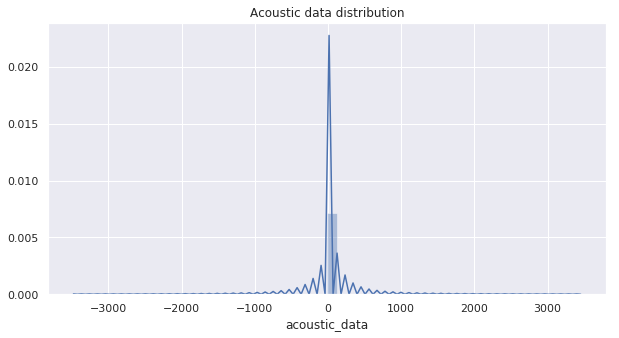

In [11]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train_sample.acoustic_data, label='Train (1% sample)')
del train_sample

There are outliers in both directions; let's try to plot the same distribution with x in the range -20 to 30. The black line is the closest normal distribution (gaussian) possible.

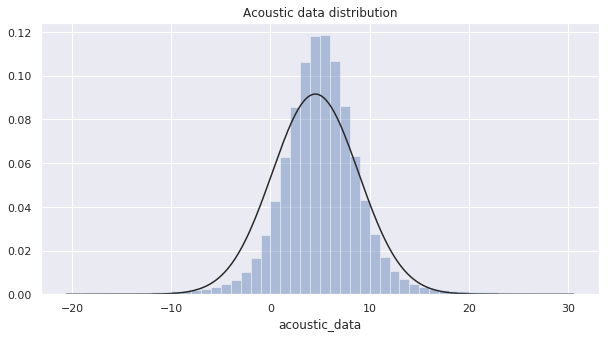

In [12]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
tmp = train_sample[train_sample.acoustic_data.between(-20, 30)]
ax = sns.distplot(tmp.acoustic_data, label='Train (1% sample)', kde=False, fit=stats.norm)
#del train_sample

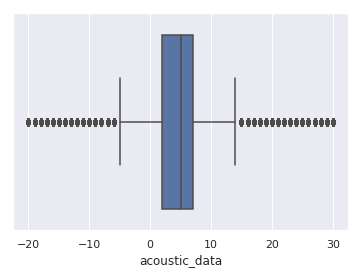

In [13]:
import seaborn as sns
sns.boxplot(x = tmp.acoustic_data)

## Time to failure
Now let's check the target variable, which is given in seconds:

In [14]:
train.time_to_failure.describe()

count    6.29145480e+08
mean     4.47708428e-01
std      2.61278939e+00
min      9.55039650e-05
25%      2.62599707e+00
50%      5.34979773e+00
75%      8.17339516e+00
max      1.61074009e+01
Name: time_to_failure, dtype: float64

The min value is very close to zero (around 10^-5) and the max is 16 seconds. Now the distribution for the random sample:

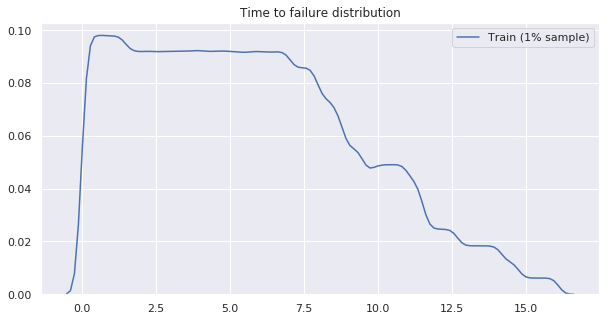

In [15]:
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.kdeplot(train_sample.time_to_failure, label='Train (1% sample)')

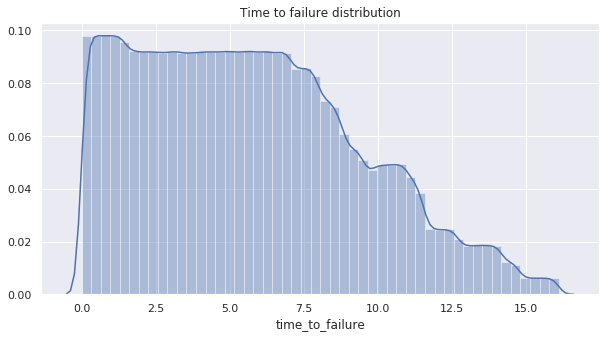

In [16]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.distplot(train_sample.time_to_failure, label='Train (1% sample)')
del train_sample

## Timeseries
Let's see how both variables change over time. The red line is the acoustic data and the blue one is the time to failure:

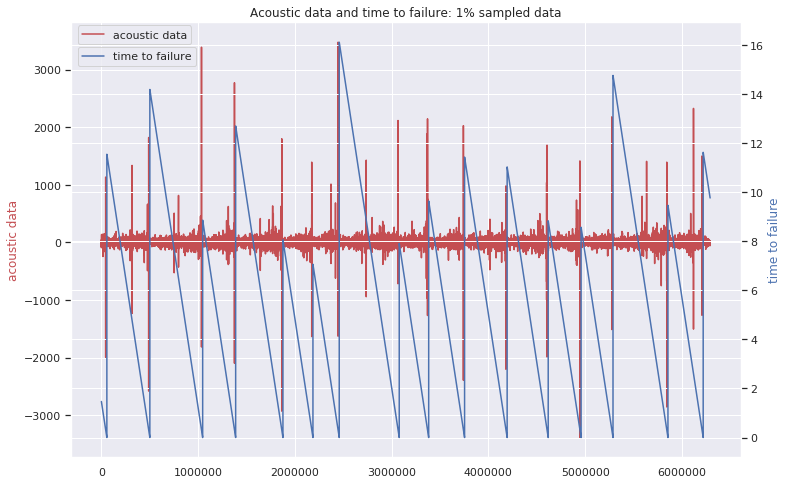

In [17]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)


On a plot above we can see, that training data has 16 earthquakes. The shortest time to failure is 1.5 seconds for the first earthquake and 7seconds for the 7th, while the longest is around 16 seconds.
* We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
* Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;

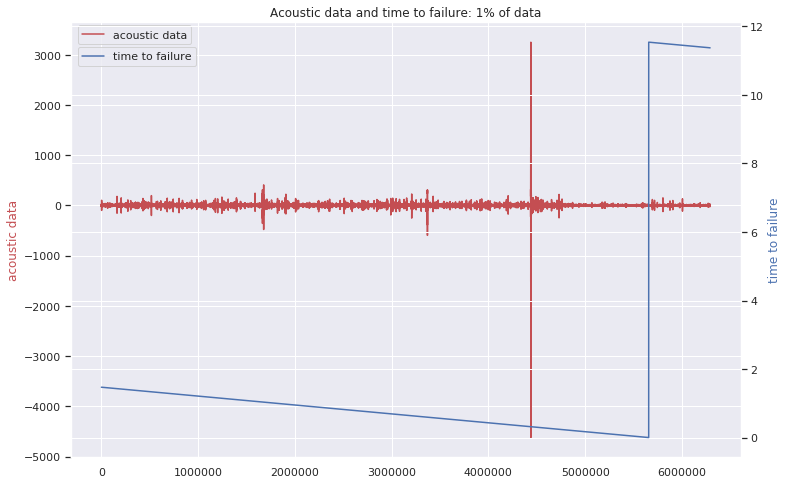

In [18]:
train_ad_sample_df_2 = train['acoustic_data'].values[:6291455]
train_ttf_sample_df_2 = train['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df_2, train_ttf_sample_df_2, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df_2
del train_ttf_sample_df_2

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.
Interesting thing to check is the time between high levels of seismic signal and the earthquakes. We are considering any acoustic data with absolute value greater than 1000 as a high level:

In [19]:
peaks = train[train.acoustic_data.abs() > 1000]
peaks.time_to_failure.describe()

count    11325.00000000
mean         0.64454830
std          1.32147193
min          0.31079626
25%          0.31549615
50%          0.31689683
75%          0.32029617
max          8.86059952
Name: time_to_failure, dtype: float64

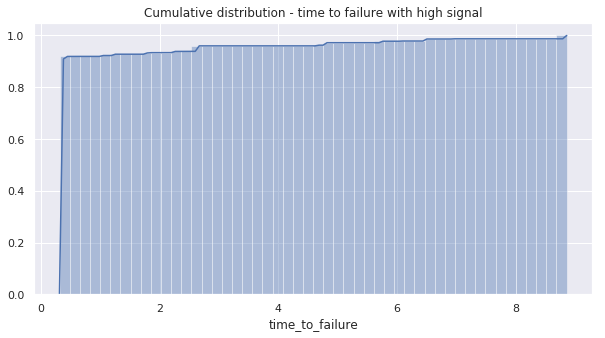

In [20]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution - time to failure with high signal")
ax = sns.distplot(peaks.time_to_failure, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
del peaks

**More than 90% of high acoustic values are around 0.31 seconds before an earthquake!**

array([1.4691   , 1.4690999, 1.4690998, ..., 9.759796 , 9.759796 ,
       9.759795 ], dtype=float32)

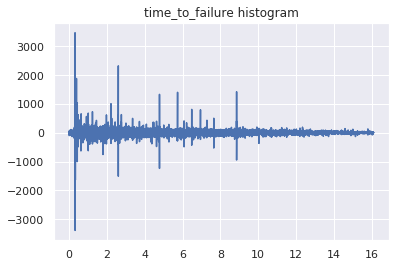

In [21]:
plt.plot(train_ttf_sample_df, train_ad_sample_df)
plt.title("time_to_failure histogram")
train_ad_sample_df
train_ttf_sample_df

Lets see the same plot as above, but without acustic outliers.

Text(0.5, 1.0, 'time_to_failure histogram')

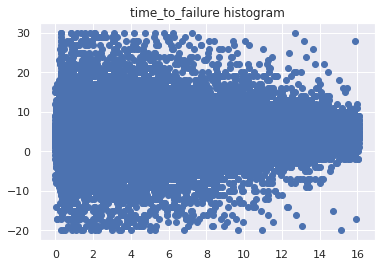

In [22]:
train_ad_sample_df = tmp['acoustic_data'].values[::100]
train_ttf_sample_df = tmp['time_to_failure'].values[::100]
plt.scatter(train_ttf_sample_df, train_ad_sample_df)
plt.title("time_to_failure histogram")

In [23]:
import gc
a = gc.collect()
del a

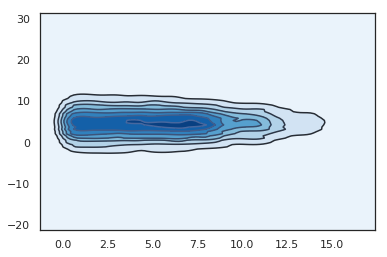

In [24]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic 2D density plot
sns.set_style("white")
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df)
#sns.plt.show()
 
# Custom it with the same argument as 1D density plot
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df, cmap="Reds", shade=True, bw=.15)
 
# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df, cmap="Blues", shade=True, shade_lowest=True, )
plt.show()


## Part I: We will divide the train data set for segments

Group the training data in chunks of 150,000 examples and extract the following features:


In [25]:
from tqdm import tqdm
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    seg = seg[seg.acoustic_data.between(-20,30)]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[-1]  # single value
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
    X_train.loc[segment, 'I_ave10%'] = x.values[:int(I_ave10)].mean()
    X_train.loc[segment, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].mean()
    X_train.loc[segment, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].mean()
    X_train.loc[segment, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].mean()
    X_train.loc[segment, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].mean()
    X_train.loc[segment, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].mean()
    X_train.loc[segment, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].mean()
    X_train.loc[segment, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].mean()
    X_train.loc[segment, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].mean()
    X_train.loc[segment, 'X_ave10%'] = x.values[int(IX_ave10):].mean()
    X_train.loc[segment, 'I_ave10%'] = x.values[:int(I_ave10)].std()
    X_train.loc[segment, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].std()
    X_train.loc[segment, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].std()
    X_train.loc[segment, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].std()
    X_train.loc[segment, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].std()
    X_train.loc[segment, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].std()
    X_train.loc[segment, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].std()
    X_train.loc[segment, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].std()
    X_train.loc[segment, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].std()
    X_train.loc[segment, 'X_ave10%'] = x.values[int(IX_ave10):].std()
    
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)
       

100%|██████████| 4194/4194 [10:10<00:00,  6.95it/s]


In [26]:
print("Train shape:", X_train.shape)
X_train_final = X_train
X_train_final.head(3)


Train shape: (4194, 98)


,ave,std,max,min,I_ave10%,II_ave10%,III_ave10%,IV_ave10%,V_ave10%,VI_ave10%,VII_ave10%,VIII_ave10%,IX_ave10%,X_ave10%,q90,q95,q99,q05,q10,q01,abs_max,abs_mean,abs_std,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_std_100,q05_roll_std_100,q10_roll_std_100,q95_roll_std_100,q99_roll_std_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,...,q10_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000,ave_roll_std_10000,std_roll_std_10000,max_roll_std_10000,min_roll_std_10000,ave_roll_mean_10000,std_roll_mean_10000,max_roll_mean_10000,min_roll_mean_10000,q01_roll_std_10000,q05_roll_std_10000,q10_roll_std_10000,q95_roll_std_10000,q99_roll_std_10000,q01_roll_mean_10000,q05_roll_mean_10000,q95_roll_mean_10000,q99_roll_mean_10000,ave_roll_abs_mean_10000,std_roll_abs_mean_10000,max_roll_abs_mean_10000,min_roll_abs_mean_10000,q01_roll_abs_mean_10000,q05_roll_abs_mean_10000,q95_roll_abs_mean_10000,q99_roll_abs_mean_10000
0,4.88324965,4.33393298,30.0,-20.0,5.96223504,3.97854200,5.11870520,3.79730596,4.61860813,4.02556844,4.07166701,3.57888624,3.24197110,4.22993122,10.0,11.0,17.0,-2.0,0.0,-7.0,30.0,5.43435094,3.61896837,3.85783368,1.97074425,16.15666670,1.93542207,4.88299824,0.45769148,9.06,2.26,2.30230451,2.47449617,2.57564349,7.92855401,12.62047399,3.79,4.15,5.58,5.97,...,2.76985850,7.50925675,9.93379486,4.072,4.379,5.359,5.540,5.43598297,0.84568811,10.887,4.110,4.339,4.588,7.170,9.00300,4.15420932,0.67380676,6.29067694,2.96722664,4.87487697,0.23897882,5.2541,4.2986,2.99622904,3.21495156,3.32939178,5.15052745,6.14874521,4.3136,4.3793,5.1874,5.2230,5.38518515,0.37268215,6.5460,4.6147,4.6406,4.70535,5.89795,6.435960
1,4.72537157,4.53560780,30.0,-20.0,5.28084350,3.39994809,5.90454914,5.00384858,4.16646489,3.65368869,3.97249123,4.65757567,4.50278330,4.22432555,10.0,11.0,18.0,-2.0,0.0,-8.0,30.0,5.39866632,3.70881067,3.97675875,2.18854171,15.50594542,1.99137027,4.72522676,0.42784729,8.47,1.10,2.29912148,2.47531245,2.57580036,9.11391571,13.33346439,3.69,4.06,5.38,5.71,...,2.72903814,8.07078116,9.79259955,4.203,4.334,5.088,5.269,5.40178618,0.93101818,10.795,4.325,4.446,4.551,7.341,8.72339,4.52252213,0.81670857,6.33183342,2.92736433,4.71304577,0.12334006,4.9409,4.4474,2.93858843,3.21021550,3.31799568,5.90927532,6.17361964,4.4634,4.5259,4.9062,4.9261,5.41245814,0.36828237,6.4147,4.6320,4.6639,4.77800,6.05490,6.298939
2,4.89672177,4.98756533,30.0,-20.0,5.62071096,4.34639585,5.22410784,5.14029686,4.06263612,4.90693520,3.61051921,3.83244457,5.70531366,6.58921870,10.0,12.0,20.0,-2.0,0.0,-11.0,30.0,5.70188534,4.04254815,4.29575483,2.53451680,16.34426350,1.96946386,4.89640606,0.50492309,8.86,0.19,2.37274082,2.53660076,2.64267618,10.54885819,14.09062773,3.59,4.15,5.64,6.14,...,2.82760321,9.29048997,10.26104599,4.226,4.426,5.337,5.469,5.70612187,1.08739108,10.487,4.394,4.512,4.716,8.279,9.11500,4.85218110,0.97294245,7.58895505,2.91094555,4.89602475,0.18007332,5.2148,4.4049,2.93506657,3.30201077,3.58698894,6.60072607,7.40939638,4.4353,4.5233,5.1550,5.1879,5.68606514,0.46809457,7.2501,4.8551,4.8768,5.06760,6.66270,7.130245


In [27]:
#https://www.kaggle.com/jsaguiar/baseline-with-multiple-models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

num_folds = 5
y = y_train.values # get the labels we want
X = X_train_final.values # use everything else to predict!
## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#  have converted them into simple matrices to use with scikit learn
# to use the cross validation object in scikit learn, we need to grab an instance
#  of the object and set it up. This object will be able to split our data into 
#  training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)



scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train)
scl_obj.fit(X_test)
X_test_scaled = scl_obj.transform(X_test)
scl_obj.fit(X)
X_scaled = scl_obj.transform(X)



ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import scipy.stats as st

grid = {
    'max_depth': [8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': [2, 6, 12],
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = RandomForestRegressor(criterion='mae',n_estimators=200)
gs1 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs1.fit(X_train_scaled, y_train.ravel())  
gs1.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 8}

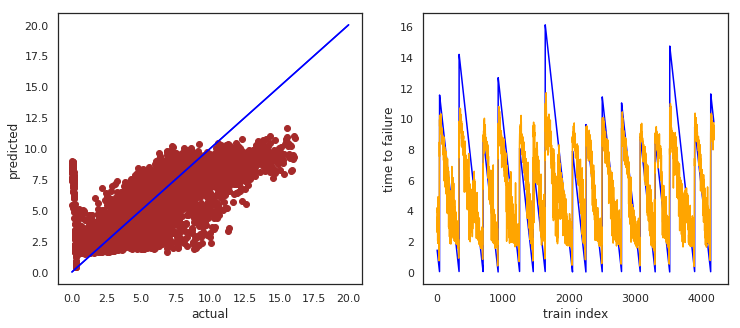

In [29]:
import matplotlib.pyplot as plt
oof_predictions = gs1.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [30]:
predictions =  gs1.predict(X_test_scaled)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))



mean_absolute_error: 2.160469314360707
r2_score: 0.45744877321402133


In [31]:
import scipy.stats as st
from xgboost.sklearn import XGBRegressor

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    #"n_estimators": st.randint(10000, 20000),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
xgbreg = XGBRegressor(nthreads=-1, n_estimators=500)  
gs2 = RandomizedSearchCV(xgbreg, params)  
gs2.fit(X_train_scaled, y_train.ravel())  
gs2.best_params_

{'colsample_bytree': 0.8451681595337441,
 'gamma': 6.38835035871956,
 'learning_rate': 0.02294941613587257,
 'max_depth': 22,
 'min_child_weight': 37.84918364313635,
 'reg_alpha': 44.268727045414124,
 'subsample': 0.8801593310585245}

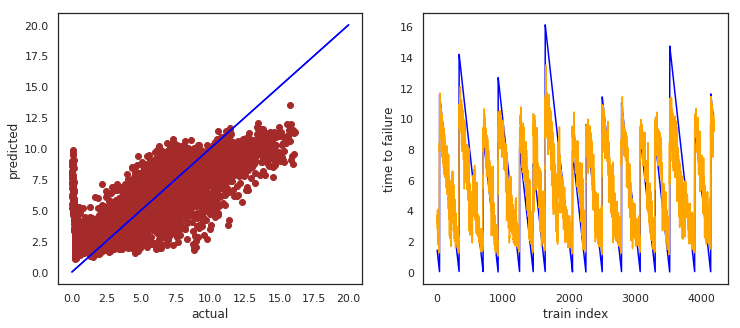

In [32]:
import matplotlib.pyplot as plt
oof_predictions = gs2.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [33]:
predictions =  gs2.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.1637227566784007
r2_score: 0.4591841562539827


In [34]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
rfr = DecisionTreeRegressor(criterion='mae')
gs3 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs3.fit(X_train_scaled, y_train.ravel())  
gs3.best_params_      

{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 86}

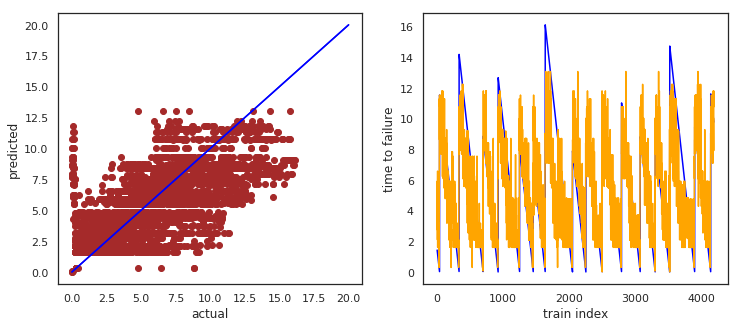

In [35]:
import matplotlib.pyplot as plt
oof_predictions = gs3.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [36]:
predictions =  gs3.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))


mean_absolute_error: 2.28983670422814
r2_score: 0.3705757194617464


In [37]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs4 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs4.fit(X_train_scaled, y_train.ravel())  
gs4.best_params_      

{'learning_rate': 0.017318835850042538, 'loss': 'square'}

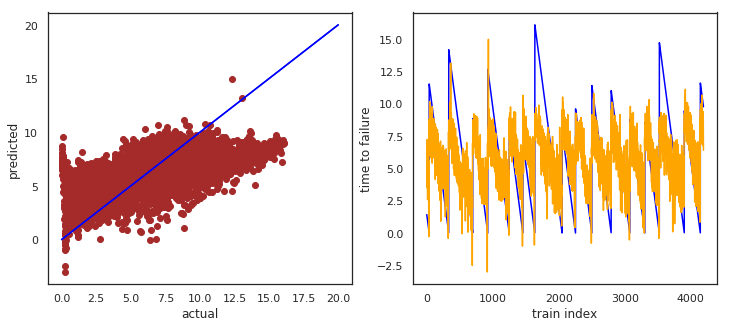

In [38]:
import matplotlib.pyplot as plt
oof_predictions = gs4.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [39]:
predictions =  gs4.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.4852027072775305
r2_score: 0.35571862148954037


The size of data is increasing day by day and it is becoming difficult for traditional data science algorithms to give faster results. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development. [https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc]

In [40]:
import lightgbm as lgb

grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs5 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs5.fit(X_train_scaled, y_train.ravel())  
gs5.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 0.8,
 'lambda_l1': 0.2,
 'lambda_l2': 0.4,
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_data_in_leaf': 20,
 'min_gain_to_split': 0.1,
 'num_leaves': 72,
 'random_seed': 22,
 'subsample': 0.8}

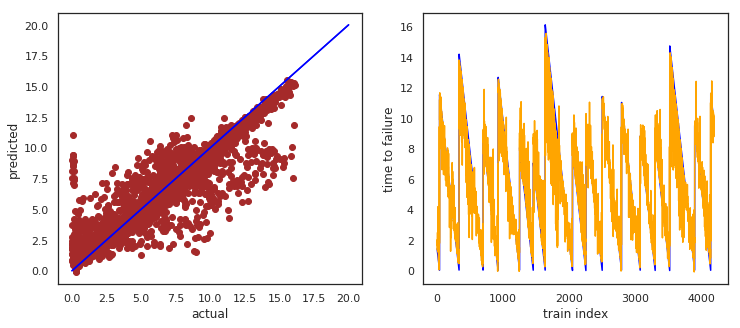

In [41]:
import matplotlib.pyplot as plt
oof_predictions = gs5.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [42]:
predictions =  gs5.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.230923263623967
r2_score: 0.42923076680297423


In [43]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': [11],
    'max_features': ['auto'],
    'min_samples_leaf': [16],
    'min_samples_split': [98],
    'n_estimators': [495],
    'min_weight_fraction_leaf':  st.uniform(0, 0.5)
    }

etr = ExtraTreesRegressor(criterion='mse')
gs6 = RandomizedSearchCV(etr, param_distributions = grid)  
gs6.fit(X_train_scaled, y_train.ravel())  
gs6.best_params_ 

{'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 16,
 'min_samples_split': 98,
 'min_weight_fraction_leaf': 0.09524949740951416,
 'n_estimators': 495}

In [44]:
predictions =  gs6.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.224443113601036
r2_score: 0.4548536303358498


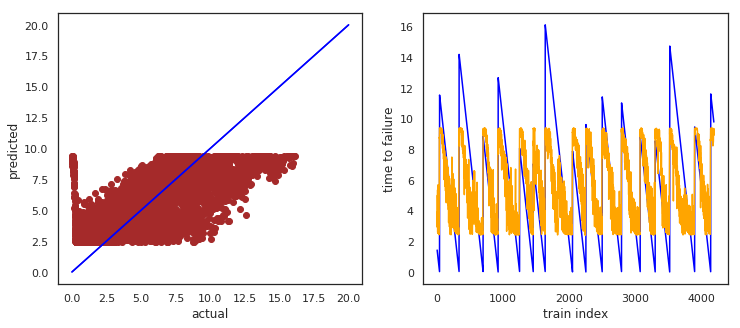

In [45]:
import matplotlib.pyplot as plt
oof_predictions = gs6.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

### PCA

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_train_final)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                          'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8',
                          'principal component 9','principal component 10'])
principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,0.20415194,1.90263541,-0.44511341,-0.27994887,0.46806692,-0.04261486,2.13741383,-0.33676648,-0.16625256,-1.18630144
1,2.21903030,1.06969485,0.22185911,-0.82817260,-0.67767399,0.18228593,0.93430378,-0.57179078,0.29959314,0.12728144
2,7.31793641,1.69644942,0.89925652,-1.02865280,-0.89605091,0.51031052,-0.38761257,-1.27406187,1.88985367,-0.87663314
3,3.63008875,1.61473959,-1.31013731,-0.63259243,-1.33720419,-2.12596387,-0.62488262,-0.93774841,-0.25777340,-0.34821837
4,6.50015903,1.85612891,-3.69270840,0.15402964,-1.04950563,-0.54439651,-0.73072125,0.47455794,-0.93782210,-1.25822446


In [47]:
pca.explained_variance_ratio_

array([0.78315058, 0.03583354, 0.02954587, 0.02025573, 0.01230492,
       0.01091889, 0.01066909, 0.00931423, 0.00859548, 0.00813404])

In [48]:
X_PCA_train_final = principalDf.values

In [49]:
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)



scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X_PCA_train_final,y): 
    
    X_PCA_train = X_PCA_train_final[train_indices]
    y_train = y[train_indices]
    
    X_PCA_test = X_PCA_train_final[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_PCA_train)
X_PCA_train = scl_obj.transform(X_PCA_train)
scl_obj.fit(X_PCA_test)
X_PCA_test = scl_obj.transform(X_PCA_test)
scl_obj.fit(X_PCA_train_final)
X_PCA = scl_obj.transform(X_PCA_train_final)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [50]:
X_PCA.shape


(4194, 10)

In [51]:
grid = {
    'max_depth': [8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': [2, 6, 12],
    #'n_estimators' : st.randint(10000, 20000),
}
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = RandomForestRegressor(criterion='mse',n_estimators=200)
gs7 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs7.fit(X_PCA_train, y_train.ravel())  
gs7.best_params_   
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

In [52]:
predictions =  gs7.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.122924690696292
r2_score: 0.43921087682750315


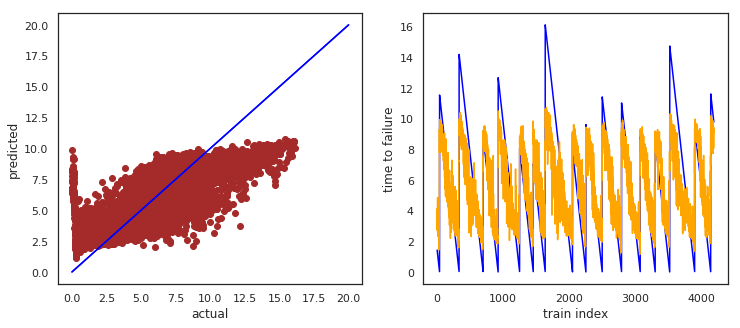

In [53]:
import matplotlib.pyplot as plt
oof_predictions = gs7.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [54]:
import scipy.stats as st
from xgboost.sklearn import XGBRegressor

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    #"n_estimators": st.randint(10000, 20000),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1,n_estimators=500, cv=5)  
gs8 = RandomizedSearchCV(xgbreg, params)  
gs8.fit(X_PCA_train, y_train.ravel())  
gs8.best_params_

{'colsample_bytree': 0.9484496536689715,
 'gamma': 6.671893330970599,
 'learning_rate': 0.035281257546377044,
 'max_depth': 23,
 'min_child_weight': 14.343377108417155,
 'reg_alpha': 36.95500540336926,
 'subsample': 0.6810543515231174}

In [55]:
predictions =  gs8.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.111265623071747
r2_score: 0.43924401053240936


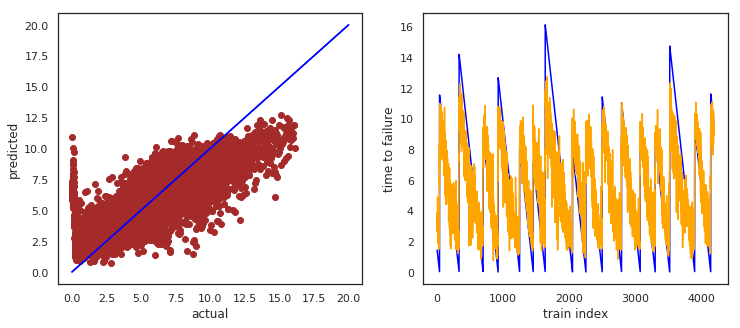

In [56]:
import matplotlib.pyplot as plt
oof_predictions = gs8.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [57]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': st.randint(4,12),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': st.randint(2,12),
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
    
rfr = DecisionTreeRegressor(criterion='mae')
gs9 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs9.fit(X_PCA_train, y_train.ravel())  
gs9.best_params_ 

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 62}

In [58]:
predictions =  gs9.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.200265914279439
r2_score: 0.3594863620551274


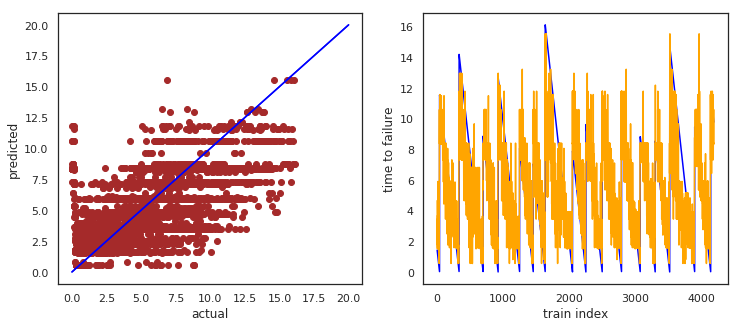

In [59]:
import matplotlib.pyplot as plt
oof_predictions = gs9.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [60]:
from sklearn.ensemble import AdaBoostRegressor

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs10 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs10.fit(X_PCA_train, y_train.ravel())  
gs10.best_params_ 

{'learning_rate': 0.2965094509874616, 'loss': 'square'}

In [61]:
predictions =  gs10.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.29466462583476
r2_score: 0.3770584620448787


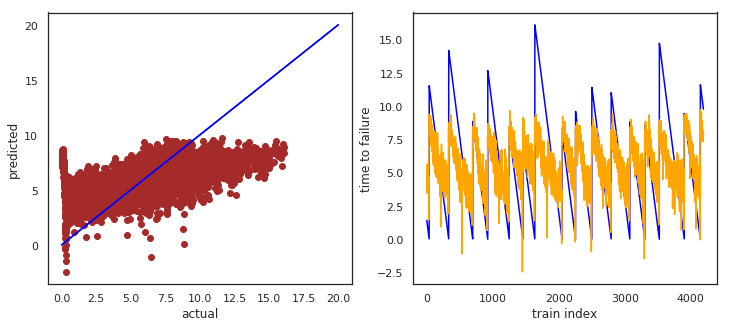

In [62]:
import matplotlib.pyplot as plt
oof_predictions = gs10.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [63]:
predictions = gs10.predict(X_PCA_test)
predictions[predictions < 0] = 0
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.2913121207960994
r2_score: 0.3777275560117772


In [64]:
import lightgbm as lgb
import scipy.stats as st

grid = {
     'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs11 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs11.fit(X_PCA_train, y_train.ravel())  
gs11.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 0.9,
 'lambda_l1': 0.2,
 'lambda_l2': 0.1,
 'learning_rate': 0.005,
 'max_depth': 6,
 'min_data_in_leaf': 100,
 'min_gain_to_split': 0.01,
 'num_leaves': 80,
 'random_seed': 66,
 'subsample': 1}

In [65]:
predictions =  gs11.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.1420167753707227
r2_score: 0.41180229333148854


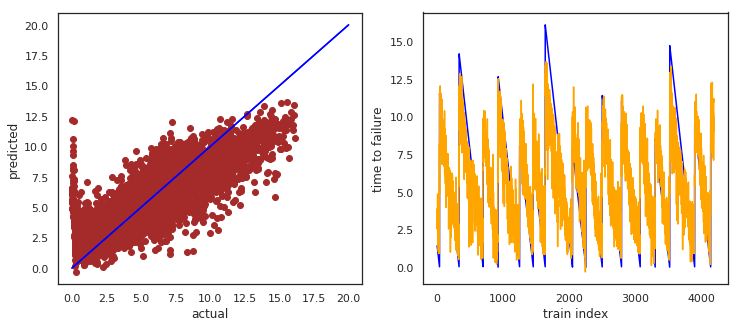

In [66]:
import matplotlib.pyplot as plt
oof_predictions = gs11.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

In [67]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': st.randint(2,20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': st.randint(2, 20),
    'min_samples_split': st.randint(10,100),
    'n_estimators': st.randint(100,10000)
    }

etr = ExtraTreesRegressor()
gs12 = RandomizedSearchCV(etr, param_distributions = grid)  
gs12.fit(X_PCA_train, y_train.ravel())  
gs12.best_params_ 

{'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 17,
 'min_samples_split': 93,
 'n_estimators': 8393}

In [68]:
predictions =  gs12.predict(X_PCA_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.1097752563343617
r2_score: 0.445814001391181


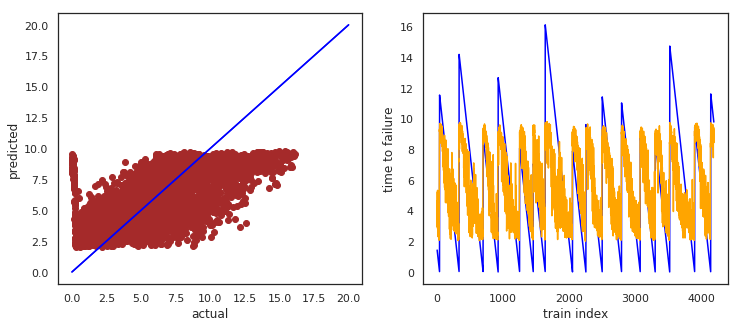

In [69]:
import matplotlib.pyplot as plt
oof_predictions = gs12.predict(X_PCA)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y, color='blue')
ax2.plot(oof_predictions, color='orange')

## Submition

In [70]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train_final.columns, dtype=np.float64, index=submission.index)

In [71]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    seg = seg[seg.acoustic_data.between(-20,30)]
    x = seg['acoustic_data']  # pd series
            
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
    X_test.loc[seg_id, 'I_ave10%'] = x.values[:int(I_ave10)].mean()
    X_test.loc[seg_id, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].mean()
    X_test.loc[seg_id, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].mean()
    X_test.loc[seg_id, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].mean()
    X_test.loc[seg_id, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].mean()
    X_test.loc[seg_id, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].mean()
    X_test.loc[seg_id, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].mean()
    X_test.loc[seg_id, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].mean()
    X_test.loc[seg_id, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].mean()
    X_test.loc[seg_id, 'X_ave10%'] = x.values[int(IX_ave10):].mean()
    X_test.loc[seg_id, 'I_ave10%'] = x.values[:int(I_ave10)].std()
    X_test.loc[seg_id, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].std()
    X_test.loc[seg_id, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].std()
    X_test.loc[seg_id, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].std()
    X_test.loc[seg_id, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].std()
    X_test.loc[seg_id, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].std()
    X_test.loc[seg_id, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].std()
    X_test.loc[seg_id, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].std()
    X_test.loc[seg_id, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].std()
    X_test.loc[seg_id, 'X_ave10%'] = x.values[int(IX_ave10):].std()
    
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [72]:
X_test.head()

,ave,std,max,min,I_ave10%,II_ave10%,III_ave10%,IV_ave10%,V_ave10%,VI_ave10%,VII_ave10%,VIII_ave10%,IX_ave10%,X_ave10%,q90,q95,q99,q05,q10,q01,abs_max,abs_mean,abs_std,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_std_100,q05_roll_std_100,q10_roll_std_100,q95_roll_std_100,q99_roll_std_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,...,q10_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000,ave_roll_std_10000,std_roll_std_10000,max_roll_std_10000,min_roll_std_10000,ave_roll_mean_10000,std_roll_mean_10000,max_roll_mean_10000,min_roll_mean_10000,q01_roll_std_10000,q05_roll_std_10000,q10_roll_std_10000,q95_roll_std_10000,q99_roll_std_10000,q01_roll_mean_10000,q05_roll_mean_10000,q95_roll_mean_10000,q99_roll_mean_10000,ave_roll_abs_mean_10000,std_roll_abs_mean_10000,max_roll_abs_mean_10000,min_roll_abs_mean_10000,q01_roll_abs_mean_10000,q05_roll_abs_mean_10000,q95_roll_abs_mean_10000,q99_roll_abs_mean_10000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.49636687,4.31859001,30.0,-20.0,4.39796926,4.55724288,3.70249649,4.29916409,4.37057831,4.59503696,3.51164439,3.26472173,4.63871206,5.42266040,9.0,11.0,17.00,-2.0,0.0,-7.0,30.0,5.11385138,3.56595832,3.86335800,1.92954273,15.88716209,2.01509455,4.49630749,0.43373468,8.24,0.91,2.34361372,2.51460381,2.61809940,7.95608527,12.68290427,3.47,3.83,5.16,5.55,...,2.80847933,7.55509254,9.98980336,3.888,4.078,4.870,5.029,5.11246702,0.86043567,9.876,4.041,4.170,4.336,6.919,8.79900,4.19040911,0.87164681,6.45806778,2.90603312,4.50781900,0.14069783,4.8155,4.2075,2.92831375,3.06525534,3.18878347,6.04693127,6.41352188,4.218600,4.2604,4.7294,4.783142,5.11017526,0.39509259,6.1850,4.4246,4.4581,4.5272,5.88722,6.1617
seg_0012b5,4.18356455,4.43651396,30.0,-20.0,3.53334785,4.66740658,5.52334682,4.74143003,4.69186428,3.91785910,4.76385809,4.23409495,4.51316054,3.32957207,9.0,11.0,17.00,-2.0,0.0,-9.0,30.0,4.91314459,3.61190791,3.87568155,2.15549000,15.89018819,2.03690694,4.18389173,0.46023982,9.32,0.08,2.31069101,2.47484312,2.57374074,8.95609943,13.57710878,3.19,3.51,4.85,5.39,...,2.77139958,8.14236096,10.92597267,3.646,3.790,4.586,4.817,4.91727075,1.04674228,10.843,3.727,3.911,4.105,7.191,9.39500,4.40851988,0.87402815,6.57209141,3.18865052,4.19233688,0.13805581,4.4941,3.8827,3.21920392,3.32622503,3.44019433,6.21531705,6.52727808,3.892400,3.9387,4.3927,4.481524,4.94434439,0.39910308,6.0814,4.3232,4.3457,4.3781,5.64460,6.0533
seg_00184e,4.61664199,4.26196222,30.0,-20.0,3.61868742,4.92113498,5.18702457,3.61919144,4.27416213,4.76436030,4.29682745,3.90540892,4.51436790,3.00504912,9.0,11.0,17.00,-2.0,0.0,-8.0,30.0,5.18941454,3.54227074,3.74959750,2.02004420,15.51921585,1.97458601,4.61687416,0.46031320,9.61,0.36,2.31193653,2.47443494,2.56038192,8.07727827,13.15515415,3.55,3.92,5.27,5.68,...,2.73906160,7.40397615,10.85008587,4.013,4.214,4.972,5.093,5.19435744,0.91768036,10.429,4.112,4.336,4.443,6.895,9.43400,4.20806855,0.91377300,6.56041017,2.98775832,4.62943805,0.15659001,4.9113,4.2334,3.00517235,3.06508291,3.13827194,5.84980614,6.27042021,4.246200,4.3925,4.8714,4.899700,5.21773092,0.37911589,6.3101,4.6045,4.6612,4.7020,5.90700,6.1692
seg_003339,4.52688115,3.54890665,30.0,-20.0,4.21406192,3.06002162,3.59879726,3.92643628,4.27989926,2.93332319,3.27833782,3.38520976,3.67298765,2.76848144,8.0,10.0,13.98,-1.0,1.0,-5.0,30.0,4.87180738,3.05824854,3.19604253,1.53662882,15.26315958,1.88947109,4.52700182,0.38570540,8.44,-0.82,2.24518250,2.38045493,2.45862736,5.97046476,11.13168378,3.63,3.92,5.13,5.39,...,2.64334558,6.54447296,8.19686187,4.032,4.184,4.906,5.043,4.87454673,0.64057011,9.344,4.

In [73]:
X_test_scaled = scl_obj.fit_transform(X_test)

In [74]:
submission['time_to_failure'] = gs5.predict(X_test_scaled)
submission[submission < 0] = 0

In [75]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.40531765
seg_0012b5,4.35367159
seg_00184e,5.57124001
seg_003339,9.92838900
seg_0042cc,7.41462798


In [76]:
submission.to_csv('submission_LGBMRegressor.csv')